In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from tqdm import tqdm
import seaborn as sns

# SETUP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


In [3]:
dataset_slug = 'adl-project-deep-armocromia'
local_dataset_path = f'/kaggle/input/{dataset_slug}/release'

print(f'Dataset path: {local_dataset_path}')
print(f'Available folders: {os.listdir(local_dataset_path)}')

Dataset path: /kaggle/input/adl-project-deep-armocromia/release
Available folders: ['grok-chat.pdf', 'RGB', 'BM', 'RGB-M', 'annotations.csv']


In [4]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


annotations_df = pd.read_csv('/kaggle/input/adl-project-deep-armocromia/release/annotations.csv')
print(annotations_df.head())
print(f"Dataset shape: {annotations_df.shape}")

season_map = {
    'primavera': 'Spring', 
    'estate': 'Summer', 
    'autunno': 'Autumn', 
    'inverno': 'Winter'
}
annotations_df['class'] = annotations_df['class'].str.lower().map(season_map)

print(annotations_df["class"].unique())
print(annotations_df["sub_class"].unique())
print("\n\n ######## SEASONS AND CHARACTERISTICS (using groupby) ###############")
season_subclasses = annotations_df.groupby('class')['sub_class'].unique()
print(season_subclasses)

     class sub_class partition  celeba                 path_rgb_original  \
0  autunno      deep     train    True  RGB/train/autunno/deep/10306.jpg   
1  autunno      deep     train    True  RGB/train/autunno/deep/10411.jpg   
2  autunno      deep     train    True  RGB/train/autunno/deep/10552.jpg   
3  autunno      deep     train    True  RGB/train/autunno/deep/11174.jpg   
4  autunno      deep     train    True  RGB/train/autunno/deep/11199.jpg   

                      path_rgb_masked                        path_mask  
0  RGB-M/train/autunno/deep/10306.png  BM/train/autunno/deep/10306.png  
1  RGB-M/train/autunno/deep/10411.png  BM/train/autunno/deep/10411.png  
2  RGB-M/train/autunno/deep/10552.png  BM/train/autunno/deep/10552.png  
3  RGB-M/train/autunno/deep/11174.png  BM/train/autunno/deep/11174.png  
4  RGB-M/train/autunno/deep/11199.png  BM/train/autunno/deep/11199.png  
Dataset shape: (4920, 7)
['Autumn' 'Summer' 'Winter' 'Spring']
['deep' 'soft' 'warm' 'cool' 'light' 'brig

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

season_le = LabelEncoder()
annotations_df['season_label'] = season_le.fit_transform(annotations_df['class'])

subclass_le = LabelEncoder()
annotations_df['subclass_label'] = subclass_le.fit_transform(annotations_df['sub_class'])

season_labels = to_categorical(annotations_df['season_label'])
subclass_labels = to_categorical(annotations_df['subclass_label'])

print("Season classes:", season_le.classes_)
print("Subclass classes:", subclass_le.classes_)

annotations_df.head()

2025-10-28 23:31:28.577192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761694288.756390      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761694288.810936      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Season classes: ['Autumn' 'Spring' 'Summer' 'Winter']
Subclass classes: ['bright' 'cool' 'deep' 'light' 'soft' 'warm']


,class,sub_class,partition,celeba,path_rgb_original,path_rgb_masked,path_mask,season_label,subclass_label
0,Autumn,deep,train,True,RGB/train/autunno/deep/10306.jpg,RGB-M/train/autunno/deep/10306.png,BM/train/autunno/deep/10306.png,0,2
1,Autumn,deep,train,True,RGB/train/autunno/deep/10411.jpg,RGB-M/train/autunno/deep/10411.png,BM/train/autunno/deep/10411.png,0,2
2,Autumn,deep,train,True,RGB/train/autunno/deep/10552.jpg,RGB-M/train/autunno/deep/10552.png,BM/train/autunno/deep/10552.png,0,2
3,Autumn,deep,train,True,RGB/train/autunno/deep/11174.jpg,RGB-M/train/autunno/deep/11174.png,BM/train/autunno/deep/11174.png,0,2
4,Autumn,deep,train,True,RGB/train/autunno/deep/11199.jpg,RGB-M/train/autunno/deep/11199.png,BM/train/autunno/deep/11199.png,0,2


In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet import preprocess_input

local_dataset_path = '/kaggle/input/adl-project-deep-armocromia/release'

def load_masked_image(row, size=(224,224)):
    img_path = os.path.join(local_dataset_path, row['path_rgb_masked'])
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, size)
    return preprocess_input(img.astype(np.float32))

def load_partition_data(partition_name, annotations_df, size=(224,224)):
    images = []
    season_y = []
    subclass_y = []

    df_subset = annotations_df[annotations_df['partition'] == partition_name]
    print(f"Loading {partition_name} images: {len(df_subset)} samples")

    for _, row in df_subset.iterrows():
        img = load_masked_image(row, size)
        if img is not None:
            images.append(img)
            season_y.append(row['season_label'])
            subclass_y.append(row['subclass_label'])

    X = np.array(images, dtype=np.float32)
    y_season = to_categorical(np.array(season_y))
    y_subclass = to_categorical(np.array(subclass_y))

    print(f"{partition_name} -> X: {X.shape}, season_y: {y_season.shape}, subclass_y: {y_subclass.shape}")
    return X, y_season, y_subclass

X_train, y_season_train, y_subclass_train = load_partition_data('train', annotations_df)
X_test, y_season_test, y_subclass_test = load_partition_data('test', annotations_df)


Loading train images: 4008 samples
train -> X: (4008, 224, 224, 3), season_y: (4008, 4), subclass_y: (4008, 6)
Loading test images: 912 samples
test -> X: (912, 224, 224, 3), season_y: (912, 4), subclass_y: (912, 6)


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
n_seasons = y_season_train.shape[1]
n_subclasses = y_subclass_train.shape[1]


base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True


inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

season_output = Dense(n_seasons, activation='softmax', name='season_output')(x)
subclass_output = Dense(n_subclasses, activation='softmax', name='subclass_output')(x)

model = Model(inputs=inputs, outputs=[season_output, subclass_output])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'season_output': 'categorical_crossentropy',
        'subclass_output': 'categorical_crossentropy'
    },
    metrics={
        'season_output': 'accuracy',
        'subclass_output': 'accuracy'
    }
)

model.summary()


I0000 00:00:1761694401.980792      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_output       │ (None, 4)         │      5,124 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subclass_output     │ (None, 6)         │      7,686 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 4,020,358 (15.34 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    X_train,
    {'season_output': y_season_train, 'subclass_output': y_subclass_train},
    epochs=25,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25


I0000 00:00:1761694468.543201      98 service.cc:148] XLA service 0x7b8ed80042f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761694468.544057      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761694473.898505      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1761694482.745941      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694482.933743      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694483.439280      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694483.6461

125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.1955 - season_output_accuracy: 0.2971 - season_output_loss: 1.3967 - subclass_output_accuracy: 0.2260 - subclass_output_loss: 1.7988

E0000 00:00:1761694529.339680      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694529.524344      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694529.710792      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694530.163875      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761694530.368235      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


126/126 ━━━━━━━━━━━━━━━━━━━━ 140s 373ms/step - loss: 3.1925 - season_output_accuracy: 0.2980 - season_output_loss: 1.3954 - subclass_output_accuracy: 0.2272 - subclass_output_loss: 1.7970 - learning_rate: 1.0000e-04
Epoch 2/25
  1/126 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - loss: 2.3020 - season_output_accuracy: 0.5625 - season_output_loss: 1.0595 - subclass_output_accuracy: 0.6562 - subclass_output_loss: 1.2424

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,season_output_accuracy,season_output_loss,subclass_output_accuracy,subclass_output_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,season_output_accuracy,season_output_loss,subclass_output_accuracy,subclass_output_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 2.4630 - season_output_accuracy: 0.5278 - season_output_loss: 1.0853 - subclass_output_accuracy: 0.4479 - subclass_output_loss: 1.3777 - learning_rate: 1.0000e-04
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - loss: 2.2484 - season_output_accuracy: 0.5724 - season_output_loss: 0.9796 - subclass_output_accuracy: 0.4973 - subclass_output_loss: 1.2687 - learning_rate: 1.0000e-04
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 1.9999 - season_output_accuracy: 0.6211 - season_output_loss: 0.8855 - subclass_output_accuracy: 0.5726 - subclass_output_loss: 1.1145 - learning_rate: 1.0000e-04
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 1.7007 - season_output_accuracy: 0.6971 - season_output_loss: 0.7469 - subclass_output_accuracy: 0.6459 - subclass_output_loss: 0.9539 - learning_rate: 1.0000e-04
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 1.4647 - season_output_accuracy: 0.7486 - se

In [10]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

# --- Predictions ---
season_pred, subclass_pred = model.predict(X_test, verbose=1)

# --- Ground Truth ---
y_season_true = np.argmax(y_season_test, axis=1)
y_subclass_true = np.argmax(y_subclass_test, axis=1)

# --- Top-1 and Top-2 Accuracy (Season) ---
def topk_accuracy(preds, labels, k=1):
    top_k = np.argsort(preds, axis=1)[:, -k:]
    correct = np.any(top_k == labels[:, None], axis=1)
    return np.mean(correct) * 100

top1_acc = topk_accuracy(season_pred, y_season_true, k=1)
top2_acc = topk_accuracy(season_pred, y_season_true, k=2)

# --- Subclass Accuracy ---
season_pred_labels = np.argmax(season_pred, axis=1)
subclass_pred_labels = np.argmax(subclass_pred, axis=1)

season_correct = np.sum(season_pred_labels == y_season_true)
subclass_correct = np.sum(subclass_pred_labels == y_subclass_true)
n_test = y_season_true.shape[0]

season_acc = season_correct / n_test * 100
subclass_acc = subclass_correct / n_test * 100

# --- Confusion Matrix & Per-Class Accuracy ---
class_names = ['Winter', 'Autumn', 'Summer', 'Spring']  # adjust if different
cm = confusion_matrix(y_season_true, season_pred_labels)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

conf_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix:\n", conf_df)
print("\nPer-Class Accuracy:")
for i, cls in enumerate(class_names):
    print(f"{cls}: {cm[i,i]} correct / {cm.sum(axis=1)[i]} total → {per_class_acc[i]*100:.2f}%")

# --- Summary Metrics for README ---
print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-2 Accuracy: {top2_acc:.2f}%")
print(f"Season Accuracy: {season_acc:.2f}%")
print(f"Subclass Accuracy: {subclass_acc:.2f}%")
print(f"Total Test Samples: {n_test}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 312ms/step

Confusion Matrix:
         Winter  Autumn  Summer  Spring
Winter     145      37      23      54
Autumn      42      88      58      15
Summer      20      56      89      21
Spring      83      16      29     136

Per-Class Accuracy:
Winter: 145 correct / 259 total → 55.98%
Autumn: 88 correct / 203 total → 43.35%
Summer: 89 correct / 186 total → 47.85%
Spring: 136 correct / 264 total → 51.52%

=== MODEL PERFORMANCE SUMMARY ===
Top-1 Accuracy: 50.22%
Top-2 Accuracy: 79.17%
Season Accuracy: 50.22%
Subclass Accuracy: 46.16%
Total Test Samples: 912


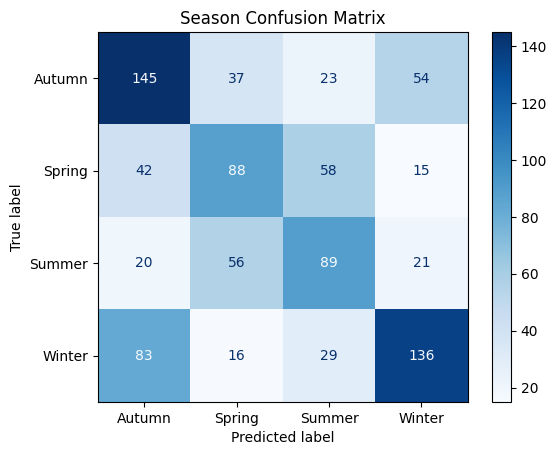

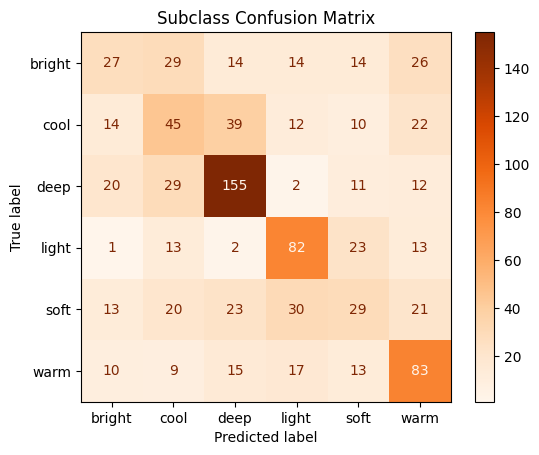

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

season_pred_labels = np.argmax(season_pred, axis=1)
subclass_pred_labels = np.argmax(subclass_pred, axis=1)

y_season_true = np.argmax(y_season_test, axis=1)
y_subclass_true = np.argmax(y_subclass_test, axis=1)

season_cm = confusion_matrix(y_season_true, season_pred_labels)
disp_season = ConfusionMatrixDisplay(confusion_matrix=season_cm, display_labels=season_le.classes_)
disp_season.plot(cmap=plt.cm.Blues)
plt.title("Season Confusion Matrix")
plt.show()

subclass_cm = confusion_matrix(y_subclass_true, subclass_pred_labels)
disp_subclass = ConfusionMatrixDisplay(confusion_matrix=subclass_cm, display_labels=subclass_le.classes_)
disp_subclass.plot(cmap=plt.cm.Oranges)
plt.title("Subclass Confusion Matrix")
plt.show()